In [1]:
import os
from os.path import join as opj
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def lineplot_org_sizes(df, size_col = 'organoid_size_pixel', 
                       filename='ground_truth_organoid_sizes_over_time.png', 
                       title='Ground truth organoid sizes',
                       y_label = 'Organoid size in pixel',
                       day_col = 'day_int',
                       ax=None,
                       ylim=None):
    if ax is None:
        sns.lineplot(df.sort_values(day_col), x=day_col, y=size_col, hue='clone')
        sns.despine()
        plt.ylabel(y_label)
        plt.xlabel('Day')
        plt.title(title)
        plt.grid()
        plt.savefig(filename, dpi=200)

    else:
        sns.lineplot(df.sort_values(day_col), x=day_col, y=size_col, hue='clone', ax=ax)
        sns.despine()
        ax.set_ylabel(y_label)
        ax.set_xlabel('Day')
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.set_title(title)
    plt.tight_layout()
    
def get_dice(pred, true, k=1):
    intersection = np.sum(pred[true == k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

def get_dice_by_files(gt_file, pred_file):
    if pred_file.endswith('.npy'):
        pred = np.load(pred_file)
    elif pred_file.endswith('.tif'):
        if 'classifier' in pred_file:
            pred = np.asarray(Image.open(pred_file))
            pred = np.where(pred==2, 0, pred)
        else:
            pred = np.asarray(Image.open(pred_file))
    else:
        raise NotImplemented
    gt = np.load(gt_file)
    dice = get_dice(pred, gt)
    return dice

def get_clone(img_id):
    if 'wt2d' in img_id.lower():
        return 'WT2D'
    elif 'b2a' in img_id.lower():
        return 'B2A'
    elif 'a1a' in img_id.lower():
        return 'A1A'
    else:
        sys.exit()
        
def get_day(img_id):
    return int(img_id.split('_')[1].replace('d', ''))

### Create dataframe based on raw data

In [3]:
img_dir = '/home/ws/oc9627/robust_monitoring_organoid_growth/data/imgs'
label_dir = '/home/ws/oc9627/robust_monitoring_organoid_growth/data/labels'

magnifications = pd.DataFrame.from_dict({'day':[2, 4, 5, 8, 10, 12, 16, 19, 22, 25], 'magnification':[5, 5, 5, 10, 10, 5, 5, 5, 5, 5]})
x5_ratio = (500/573)**2 # 500 mikrometer are 573 px for magnification 5x -> **2 to adjust for area
x10_ratio = (200/468)**2
px_mikrometer_ratio = pd.DataFrame.from_dict({'day':[2, 4, 5, 8, 10, 12, 16, 19, 22, 25], 'px_mikrom_ratio':[x5_ratio, x5_ratio, x5_ratio, x10_ratio, x10_ratio, x5_ratio, x5_ratio, x5_ratio, x5_ratio, x5_ratio]})


df = pd.DataFrame.from_dict({'img': [opj(img_dir, x) for x in sorted(os.listdir(img_dir))]})
df['img_id'] = df['img'].apply(lambda x: os.path.basename(x).replace('.jpg', ''))
df['mask'] = df['img_id'].apply(lambda x: opj(label_dir, f'{x}.npy'))
df['day'] = df['img_id'].apply(lambda x: get_day(x))
df['clone'] = df['img_id'].apply(lambda x: get_clone(x))
df['org_size_pixel2'] = df['mask'].apply(lambda x: np.count_nonzero(np.load(x)))
df = df.merge(magnifications, on='day')
df = df.merge(px_mikrometer_ratio, on='day')

df['org_size_mikrometer2'] = df.apply(lambda x: x['org_size_pixel2']*x['px_mikrom_ratio'], axis=1)

print(df.shape)

df = df.sort_values(['day', 'clone']).reset_index(drop=True)

(450, 9)


In [4]:
df

,img,img_id,mask,day,clone,org_size_pixel2,magnification,px_mikrom_ratio,org_size_mikrometer2
0,/home/ws/oc9627/robust_monitoring_organoid_gro...,10_d2_A1A,/home/ws/oc9627/robust_monitoring_organoid_gro...,2,A1A,35345,5,0.761431,26912.791742
1,/home/ws/oc9627/robust_monitoring_organoid_gro...,11_d2_A1A,/home/ws/oc9627/robust_monitoring_organoid_gro...,2,A1A,36148,5,0.761431,27524.221132
2,/home/ws/oc9627/robust_monitoring_organoid_gro...,12_d2_A1A,/home/ws/oc9627/robust_monitoring_organoid_gro...,2,A1A,35646,5,0.761431,27141.982585
3,/home/ws/oc9627/robust_monitoring_organoid_gro...,13_d2_A1A,/home/ws/oc9627/robust_monitoring_organoid_gro...,2,A1A,33332,5,0.761431,25380.030396
4,/home/ws/oc9627/robust_monitoring_organoid_gro...,14_d2_A1A,/home/ws/oc9627/robust_monitoring_organoid_gro...,2,A1A,36124,5,0.761431,27505.946779
...,...,...,...,...,...,...,...,...,...
445,/home/ws/oc9627/robust_monitoring_organoid_gro...,446_d25_WT2D,/home/ws/oc9627/robust_monitoring_organoid_gro...,25,WT2D,278505,5,0.761431,212062.443464
446,/home/ws/oc9627/robust_monitoring_organoid_gro...,447_d25_WT2D,/home/ws/oc9627/robust_monitoring_organoid_gro...,25,WT2D,237966,5,0.761431,181194.777190
447,/home/ws/oc9627/robust_monitoring_organoid_gro...,448_d25_WT2D,/home/ws/oc9627/robust_monitoring_organoid_gro...,25,WT2D,267526,5,0.761431,203702.688462
448,/home/ws/oc9627/robust_monitoring_organoid_gro...,449_d25_WT2D,/home/ws/oc9627/robust_monitoring_organoid_gro...,25,WT2D,209535,5,0.761431,159546.521934


### Plot example segmentation

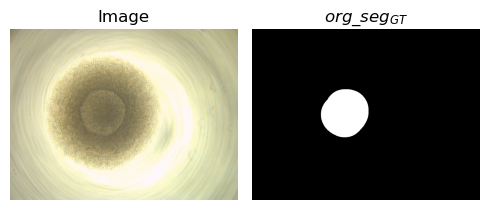

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(5, 5))

axs[0].imshow(Image.open(df.iloc[2]['img']))
axs[1].imshow(np.load(df.iloc[2]['mask']), cmap='Greys_r')
img_id = df.iloc[2]['img_id']
for i in range(2):
    axs[i].axis('off')
    
axs[0].set_title('Image')
axs[1].set_title(r'$org\_seg_{GT}$')
plt.tight_layout()
plt.savefig('plots/example_gt_segmentation.png', dpi=300)

### Calculate Dice scores for all models

In [6]:
inf_dirs = ['model_predictions/morgana/LR',
           'model_predictions/morgana/LR',
           'model_predictions/morgana/MLP',
           'model_predictions/morgana/MLP',
            'model_predictions/segformer',]
model_names = ['MOrgAna_LR_C', 'MOrgAna_LR_W', 'MOrgAna_MLP_C', 'MOrgAna_MLP_W', 'SegFormer']
endswiths = ['_classifier.tif', '_watershed.tif', '_classifier.tif', '_watershed.tif', '.npy']

df_pred = df.copy()
i = 0
for inf_dir, model_name in zip(inf_dirs, model_names):
    endswith = endswiths[i]
    df_inf = pd.DataFrame.from_dict({'img_id': [x.replace(endswith, '') for x in os.listdir(inf_dir) if x.endswith(endswith)],
                                                 f'pred_{model_name}': [opj(inf_dir, x) for x in os.listdir(inf_dir) if x.endswith(endswith)]})
    if endswith == '.npy':
        df_inf[f'pred_{model_name}_org_size'] = df_inf[f'pred_{model_name}'].apply(lambda x: np.count_nonzero(np.load(x)))
    elif endswith == '_watershed.tif':
        df_inf[f'pred_{model_name}_org_size'] = df_inf[f'pred_{model_name}'].apply(lambda x: np.count_nonzero(np.asarray(Image.open(x))))
    elif endswith == '_classifier.tif':
        df_inf[f'pred_{model_name}_org_size'] = df_inf[f'pred_{model_name}'].apply(lambda x: np.count_nonzero(np.asarray(Image.open(x))))
    df_pred = df_pred.merge(df_inf, on='img_id')
    df_pred[f'pred_{model_name}_mag_adj_org_size'] = df_pred.apply(lambda x: x[f'pred_{model_name}_org_size']/4 if x['magnification']==10 else x[f'pred_{model_name}_org_size'], axis=1)
    df_pred[f'pred_{model_name}_org_size_mum2'] = df_pred.apply(lambda x: (x[f'pred_{model_name}_org_size']*x['px_mikrom_ratio']), axis=1)
    i += 1

pred_cols = [f'pred_{mn}' for mn in model_names]
for pred_col in pred_cols:
    df_pred[pred_col+'_dice'] = df_pred.apply(lambda x: get_dice_by_files(x['mask'], x[pred_col]), axis=1)
    
df_pred.shape

(450, 34)

### Plot Dice scores

/home/ws/oc9627/anaconda3/envs/data_processing/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


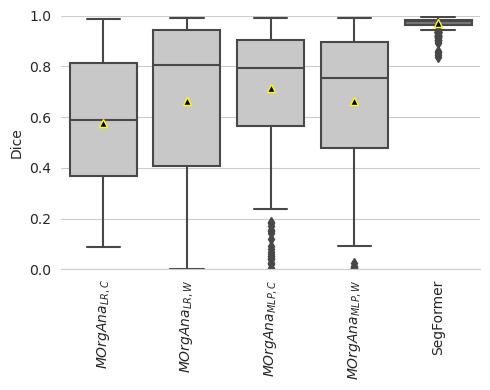

In [7]:
plt.figure(figsize=(5, 4))
sns.set_style('whitegrid')
# palette = ['#787878', '#969696', '#C8C8C8'][::-1]
palette = ['#C8C8C8', '#C8C8C8', '#C8C8C8', '#C8C8C8', '#787878']

keep_cols = ['img_id'] + [f'{pc}_dice' for pc in pred_cols]

d = df_pred[keep_cols]
mean_props = {'markerfacecolor': 'black', 'markeredgecolor': 'yellow'}
sns.boxplot(data=d.rename(columns={'pred_MOrgAna_LR_C_dice': r'$MOrgAna_{LR, C}$',
                                  'pred_MOrgAna_LR_W_dice': r'$MOrgAna_{LR, W}$',
                                  'pred_MOrgAna_MLP_C_dice': r'$MOrgAna_{MLP, C}$',
                                  'pred_MOrgAna_MLP_W_dice': r'$MOrgAna_{MLP, W}$',
                                  'pred_SegFormer_dice': 'SegFormer'}), showmeans=True,
           meanprops=mean_props, whis=1.0, palette=palette)#, palette=palette, linewidth=1)
_ = plt.xticks(rotation = 90)
plt.ylabel('Dice')

plt.ylim((0, 1))
sns.despine(top=True, left=True)
plt.tight_layout()
plt.savefig('plots/dice_scores_segformer_vs_morgana.png', dpi=300)

##### Mean and SD of Dice scores

In [8]:
df_pred[[f'{pc}_dice' for pc in pred_cols]].mean()

pred_MOrgAna_LR_C_dice     0.576097
pred_MOrgAna_LR_W_dice     0.663985
pred_MOrgAna_MLP_C_dice    0.713185
pred_MOrgAna_MLP_W_dice    0.662422
pred_SegFormer_dice        0.969844
dtype: float64

In [9]:
df_pred[[f'{pc}_dice' for pc in pred_cols]].std()

pred_MOrgAna_LR_C_dice     0.261638
pred_MOrgAna_LR_W_dice     0.316290
pred_MOrgAna_MLP_C_dice    0.240892
pred_MOrgAna_MLP_W_dice    0.289124
pred_SegFormer_dice        0.022573
dtype: float64

### Per day dice scores

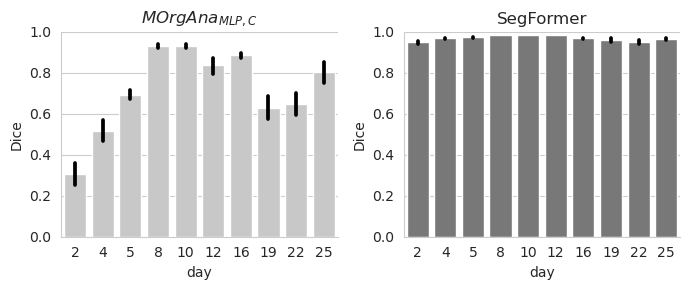

In [10]:
cols = ['pred_SegFormer_dice', 'pred_MOrgAna_MLP_C_dice'][::-1]
y_labels = ['Dice SegFormer', 'Dice MOrgAna'][::-1]
palette = ['#C8C8C8', '#787878']

fig, axs = plt.subplots(1, len(cols), figsize=(7, 3))
palette2 = palette[:1] + palette[-1:]
for i, col in enumerate(cols):
    ax = sns.barplot(data=df_pred, x='day', y=col, orient='v', ax=axs[i], color=palette[i], errcolor='black')
    axs[i].set_ylabel('Dice')
#     _ = ax.bar_label(ax.containers[0], fmt='%0.3f')
    axs[i].set_ylim((0.0, 1.0))
axs[0].set_title(r'$MOrgAna_{MLP, C}$')
axs[1].set_title('SegFormer')
sns.despine()
plt.tight_layout()
plt.savefig('plots/dice_scores_per_day_segformer_vs_morgana.png', dpi=300)

### Compare predictions per day

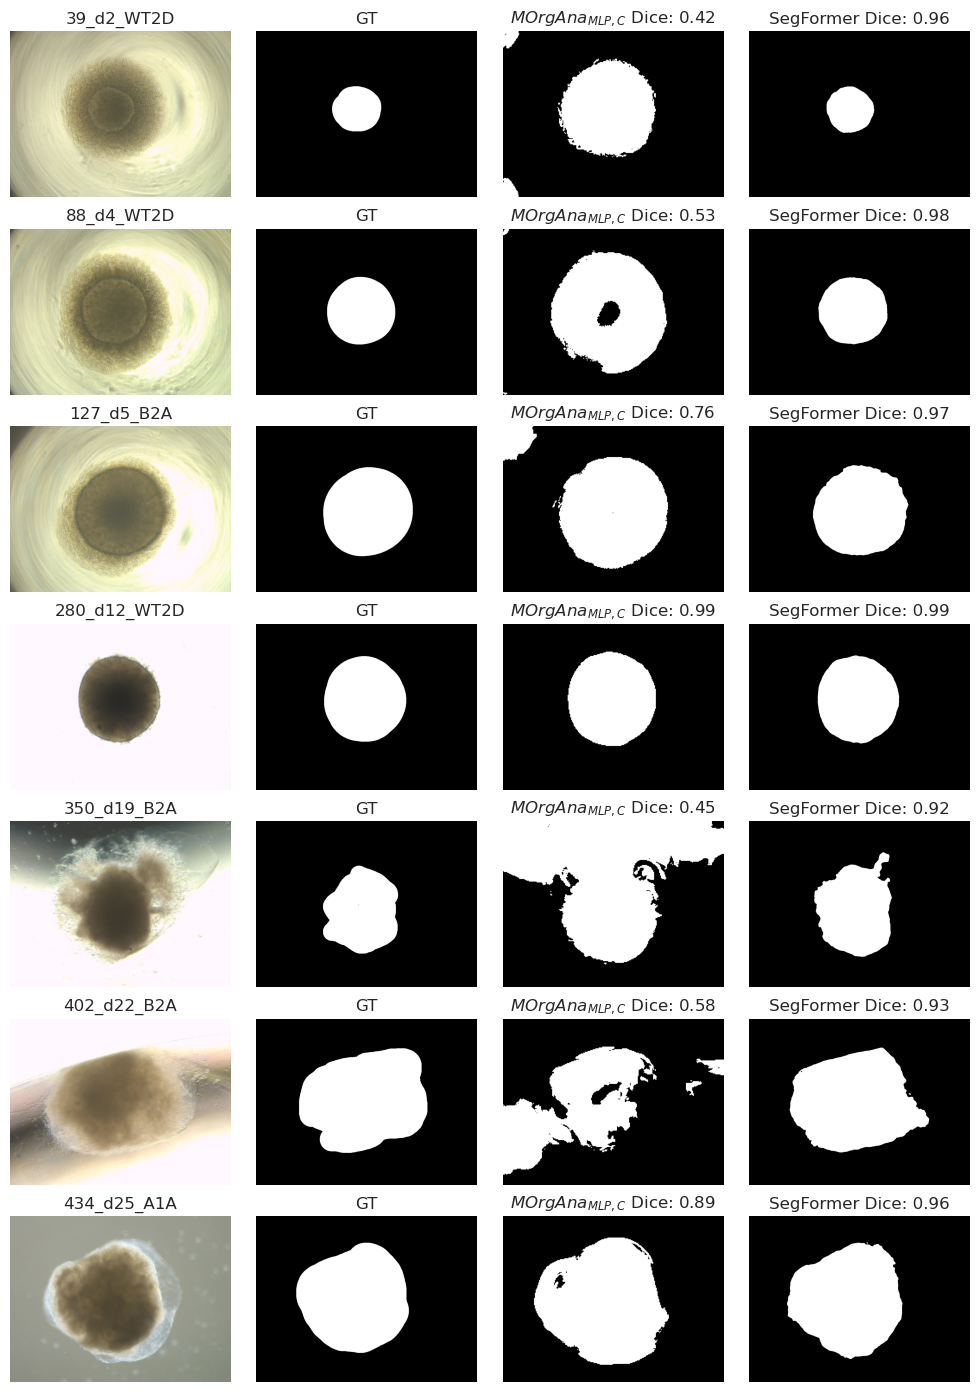

In [11]:
morg_col = 'MOrgAna_MLP_C'
morg_classifier = True

randomly_sampled_img_ids = ['39_d2_WT2D',
                             '88_d4_WT2D',
                             '127_d5_B2A',
                             '280_d12_WT2D',
                             '350_d19_B2A',
                             '402_d22_B2A',
                             '434_d25_A1A']

x = df_pred[df_pred['img_id'].isin(randomly_sampled_img_ids)].sort_values('day').reset_index(drop=True)
nr_rows, nr_cols = x.shape[0], 4
cell_width, cell_height = 2.5, 2
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*cell_width, nr_rows*cell_height))
for i, row in x.iterrows():
    img_id = row['img_id']
    axs[i, 0].imshow(Image.open(row['img']))
    axs[i, 1].imshow(np.load(row['mask']), cmap='Greys_r')
    axs[i, 1].set_title('GT')
    img = np.asarray(Image.open(row[f'pred_{morg_col}']))
    if morg_classifier:
        img = np.where(img==2, 1, img)
    axs[i, 2].imshow(img*-1, cmap='Greys')
    axs[i, 2].set_title(r'$MOrgAna_{MLP, C}$'+f' Dice: {row[f"pred_{morg_col}_dice"]:.2f}')
    axs[i, 3].imshow(np.load(row['pred_SegFormer'])*-1, cmap='Greys')
    axs[i, 3].set_title(f'SegFormer Dice: {row["pred_SegFormer_dice"]:.2f}')
    for j in range(4):
        axs[i, j].axis('off')
    axs[i, 0].set_title(img_id)
# axs[0, 2].set_title('MOrgAna')
# axs[0, 3].set_title('SegFormer')
plt.tight_layout()
plt.savefig('plots/morgana_mlp_c_vs_segformer_one_example_per_day_selected.png', dpi=300)

### Comparison of growth monitoring

##### Absolute

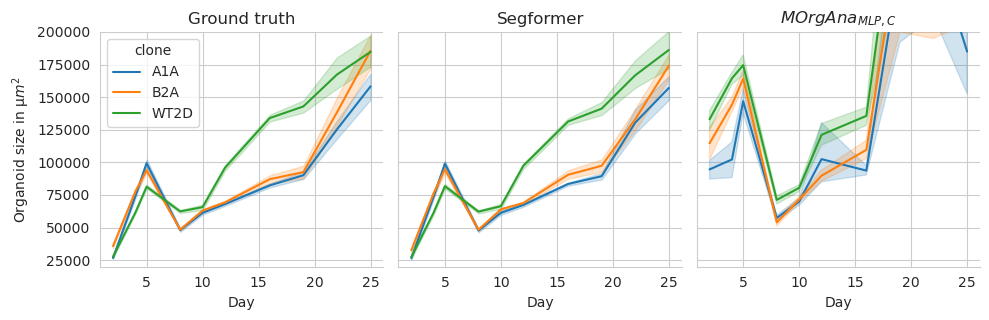

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3.3), sharey=True)
# sns.set()

sns.set_style('whitegrid')

y_label = u'Organoid size in \u03bc' +r'$m^2$'
ylim = (20000, 200000)
lineplot_org_sizes(df_pred, size_col='org_size_mikrometer2',
                   filename='', 
                   y_label=y_label,
                   title='Ground truth',
                   day_col = 'day', ax=axs[0],
                   ylim=ylim)
lineplot_org_sizes(df_pred, size_col='pred_MOrgAna_MLP_C_org_size_mum2',
                   filename='', 
                   y_label=y_label,
                   title=r'$MOrgAna_{MLP, C}$',
                   day_col = 'day', ax=axs[2],
                   ylim=ylim)
lineplot_org_sizes(df_pred, size_col='pred_SegFormer_org_size_mum2',
                   filename='', 
                   title='Segformer',
                   y_label=y_label,
                   day_col = 'day', ax=axs[1],
                   ylim=ylim)
axs[1].legend().set_visible(False)
axs[2].legend().set_visible(False)
# axs[1].get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig('plots/gt_vs_morgana_vs_segformer_org_size.png', dpi=1000)



##### Relative to WT2D

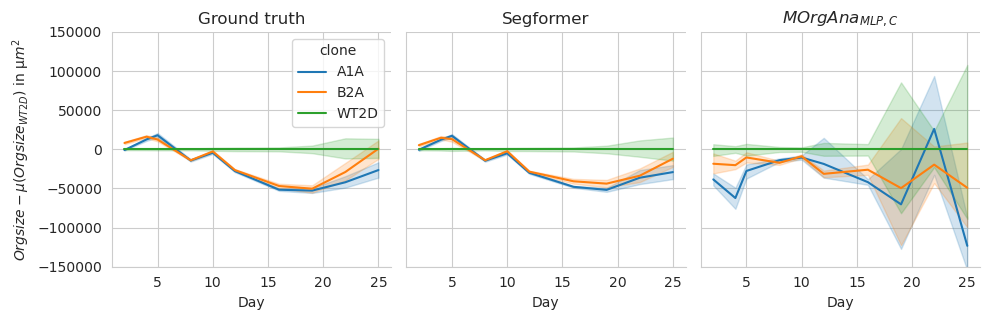

In [13]:
df_pred_x = df_pred.copy()
pd.set_option("display.precision", 10)

### Calculate WT2D average for GT, SegFormer and MorgAna
x = df_pred_x[df_pred_x['clone'] == 'WT2D'][['day', 'org_size_mikrometer2']].groupby('day').aggregate('mean')
y = df_pred_x[df_pred_x['clone'] == 'WT2D'][['day', 'pred_SegFormer_org_size_mum2']].groupby('day').aggregate('mean')
z = df_pred_x[df_pred_x['clone'] == 'WT2D'][['day', 'pred_MOrgAna_MLP_C_org_size_mum2']].groupby('day').aggregate('mean')
mean_wt_per_day_GT = x.rename({'org_size_mikrometer2': 'org_size_mikrometer2_mean_WT_per_day_GT'}, axis=1)
mean_wt_per_day_SegFormer = y.rename({'pred_SegFormer_org_size_mum2': 'org_size_mikrometer2_mean_WT_per_day_SegFormer'}, axis=1)
mean_wt_per_day_Morgana = z.rename({'pred_MOrgAna_MLP_C_org_size_mum2': 'org_size_mikrometer2_mean_WT_per_day_Morgana'}, axis=1)
df_pred_x = df_pred_x.merge(mean_wt_per_day_GT, on='day')
df_pred_x = df_pred_x.merge(mean_wt_per_day_SegFormer, on='day')
df_pred_x = df_pred_x.merge(mean_wt_per_day_Morgana, on='day')

### calculate deviation to WT2D average
df_pred_x['org_size_mikrometer2_rel_wt'] = df_pred_x.apply(lambda x: x['org_size_mikrometer2'] - x['org_size_mikrometer2_mean_WT_per_day_GT'], axis = 1)
df_pred_x['pred_SegFormer_org_size_mum2_rel_wt'] = df_pred_x.apply(lambda x: x['pred_SegFormer_org_size_mum2']- x['org_size_mikrometer2_mean_WT_per_day_SegFormer'], axis = 1)
df_pred_x['pred_MOrgAna_MLP_C_org_size_mum2_rel_wt'] = df_pred_x.apply(lambda x: x['pred_MOrgAna_MLP_C_org_size_mum2']- x['org_size_mikrometer2_mean_WT_per_day_Morgana'], axis = 1)

fig, axs = plt.subplots(1, 3, figsize=(10, 3.3), sharey=True)
# sns.set()

sns.set_style('whitegrid')

y_label = r'$Orgsize - \mu(Orgsize_{WT2D})$ in ' +u'\u03bc' +r'$m^2$'
ylim = (-150000, 150000)
lineplot_org_sizes(df_pred_x, size_col='org_size_mikrometer2_rel_wt',
                   filename='', 
                   y_label=y_label,
                   title='Ground truth',
                   day_col = 'day', ax=axs[0],
                   ylim=ylim)
lineplot_org_sizes(df_pred_x, size_col='pred_MOrgAna_MLP_C_org_size_mum2_rel_wt',
                   filename='', 
                   y_label=y_label,
                   title=r'$MOrgAna_{MLP, C}$',
                   day_col = 'day', ax=axs[2],
                   ylim=ylim)
lineplot_org_sizes(df_pred_x, size_col='pred_SegFormer_org_size_mum2_rel_wt',
                   filename='', 
                   title='Segformer',
                   y_label=y_label,
                   day_col = 'day', ax=axs[1],
                   ylim=ylim)
axs[1].legend().set_visible(False)
axs[2].legend().set_visible(False)
# axs[1].get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig('plots/gt_vs_morgana_vs_segformer_org_size_rel_to_wt.png', dpi=1000)


### Mean difference to ground truth

#### Absolute in mikrometer2

In [14]:
df_pred_x = df_pred.copy()

df_pred_x['SegFormer_diff_org_size'] = df_pred_x['pred_SegFormer_org_size_mum2'] - df_pred_x['org_size_mikrometer2']
df_pred_x['MOrgAna_diff_org_size'] = df_pred_x['pred_MOrgAna_MLP_C_org_size_mum2'] - df_pred_x['org_size_mikrometer2']

pd.set_option("display.precision", 0)
df_pred_x[['day', 'SegFormer_diff_org_size', 'MOrgAna_diff_org_size']].groupby('day').aggregate('mean')


,SegFormer_diff_org_size,MOrgAna_diff_org_size
day,,
2,-1171,84064
4,-576,65810
5,285,70297
8,-205,7896
10,563,10589
12,57,26781
16,677,12047
19,840,174554
22,-176,99983


##### Relative

In [15]:
df_pred_x = df_pred.copy()

df_pred_x['SegFormer_diff_org_size'] = ((df_pred_x['pred_SegFormer_org_size_mum2'] /df_pred_x['org_size_mikrometer2'])*100) - 100
df_pred_x['MOrgAna_diff_org_size'] = ((df_pred_x['pred_MOrgAna_MLP_C_org_size_mum2']/ df_pred_x['org_size_mikrometer2'])*100) -100

pd.set_option("display.precision", 1)

df_pred_x[['day', 'SegFormer_diff_org_size', 'MOrgAna_diff_org_size']].groupby('day').aggregate('mean')


,SegFormer_diff_org_size,MOrgAna_diff_org_size
day,,
2,-3.3,286.1
4,-0.7,97.3
5,0.3,79.5
8,-0.4,15.1
10,0.9,16.7
12,-0.1,36.0
16,1.2,14.2
19,1.3,167.2
22,0.4,78.1
